### Data import
Importing and merging aggregated data from https://www.ckw.ch/lp/opendata.html 
Aggregated data: Summed consumption per time window per municipality

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as md
%matplotlib inline
import datetime
import ics
from ics import Calendar
import calendar
from urllib.request import urlopen
from csv_ical import Convert
from dateutil import parser
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm

In [43]:
# Data import 2024

dfs24 = {} 
for i in range(202401, 202404):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://open.data.axpo.com/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs24["dataset{0}".format(i)] = loadData()

In [44]:
# Data import 2023

dfs23 = {} 
for i in range(202301, 202313):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://open.data.axpo.com/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs23["dataset{0}".format(i)] = loadData()

In [45]:
# Data import 2022

dfs22 = {} 
for i in range(202201, 202213):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs22["dataset{0}".format(i)] = loadData()

In [46]:
# Data import 21

dfs21 = {}
for i in range(202101, 202113):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://open.data.axpo.com/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs21["dataset{0}".format(i)] = loadData()

In [47]:
# Initialize an empty list to store datasets
datasets = []

# Iterate over dfs_list and concatenate datasets
for dfs in [dfs24, dfs23, dfs22, dfs21]:
    for dataset_key, dataset_value in dfs.items():
        datasets.append(dataset_value)

# Concatenate datasets
df_init = pd.concat(datasets, ignore_index=True)

df_init.to_pickle("inital_load.pkl") # Save localy

In [3]:
# Data preparation
df_prep = pd.read_pickle("inital_load.pkl")
df_prep['timestamp'] = pd.to_datetime(df_prep['timestamp']).dt.tz_convert('Europe/Berlin')
df_prep['timestamp'] = pd.to_datetime(df_prep['timestamp'], format="%Y-%m-%dT%H:%M:%S.%fZ", errors = 'coerce')

# Date variables
df_prep['date'] = df_prep['timestamp'].dt.date
df_prep["date"] = pd.to_datetime(df_prep["date"], format='%Y-%m-%d')
df_prep['month'] = df_prep['timestamp'].dt.month
df_prep['year'] = df_prep['timestamp'].dt.year
df_prep['timestamp'] = df_prep['timestamp'].dt.time
df_prep['timestamp'] = pd.to_datetime(df_prep['timestamp'], format='%H:%M:%S')
df_prep['weekday']= df_prep['date'].dt.day_name()
df_prep = df_prep[~(df_prep["year"]=="2020")] # Delete values from 2020

df_prep.to_pickle("data_prep.pkl") # Save localy


#### Import of public weather data 


In [8]:
# Import weather data of the current year
df_prep_tmp = pd.read_pickle("data_prep.pkl")
df_tmp_cur= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_current.csv', delimiter= ';')
df_tmp_cur=df_tmp_cur[['tre200d0', 'prestad0', 'station/location', 'date']]
df_tmp_cur["date"] = pd.to_datetime(df_tmp_cur["date"], format='%Y%m%d')
df_tmp_cur.rename(columns={'tre200d0':'daytemp','prestad0': "airpress"}, inplace=True)

In [9]:
# Import weather data of the past years
df_tmp_pre= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_previous.csv', delimiter= ';')
df_tmp_pre=df_tmp_pre[['tre200d0', 'prestad0', 'station/location', 'date']]
df_tmp_pre["date"] = pd.to_datetime(df_tmp_pre["date"], format='%Y%m%d')
df_tmp_pre.rename(columns={'tre200d0':'daytemp','prestad0': "airpress"}, inplace=True)

df_temp = pd.concat([df_tmp_cur, df_tmp_pre], ignore_index=True,axis=0) # Concat current and past
df_prep_tmp = pd.merge(df_prep, df_temp, how="left", on=["date"]) # Merge with smart meter data
df_prep_tmp
df_prep_tmp.to_pickle("data_prep_tmp.pkl") # Save localy

In [4]:

# Additional features
#df_add = pd.read_pickle("data_prep_tmp.pkl")
df_add = pd.read_pickle("data_prep.pkl")
#Average consumption per smart meter per municipality
df_add['kwh_per_meter'] = df_add['value_kwh']/df_add['num_meter']

df_add['kwh_datetime']=df_add.groupby(['date', 'timestamp'])['value_kwh'].transform('sum') # Total kwh per timestamp
df_add['num_meter_datetime']=df_add.groupby(['date', 'timestamp'])['num_meter'].transform('sum') # Total smart meter per timestamp
df_add['kwh_num_meter_datetime']=df_add['kwh_datetime']/df_add['num_meter_datetime'] # KWh per timestamp and smart meter

In [5]:
# Ergänzung Saison 

# Column for the four seasons
df_add.loc[(df_add['month'] == 12) | (df_add['month'] == 1) | (df_add['month'] == 2) , 'season'] = 'Winter' # Neue Spalte mit "Winter" für Wintermonate
df_add.loc[(df_add['month'] == 3) | (df_add['month'] == 4) | (df_add['month'] == 5) , 'season'] = 'Frühling' # "Frühling" für Frühlingsmonate
df_add.loc[(df_add['month'] == 6) | (df_add['month'] == 7) | (df_add['month'] == 8) , 'season'] = 'Sommer' # "Sommer" für Sommermonate
df_add.loc[(df_add['month'] == 9) | (df_add['month'] == 10) | (df_add['month'] == 11) , 'season'] = 'Herbst'

# Column for winter halfyear
df_add.loc[(((df_add['month'] == 10) | (df_add['month'] == 11) | (df_add['month'] == 12)) & (df_add['year'] == 2021))  | (((df_add['month'] == 1) | (df_add['month'] == 2) | (df_add['month'] == 3)) & (df_add['year'] == 2022)), 'seasonyear'] = 'Winter 2021/2022' 
df_add.loc[(((df_add['month'] == 10) | (df_add['month'] == 11) | (df_add['month'] == 12)) & (df_add['year'] == 2022))  | (((df_add['month'] == 1) | (df_add['month'] == 2) | (df_add['month'] == 3)) & (df_add['year'] == 2023)), 'seasonyear'] = 'Winter 2022/2023'
df_add.loc[(((df_add['month'] == 10) | (df_add['month'] == 11) | (df_add['month'] == 12)) & (df_add['year'] == 2023))  | (((df_add['month'] == 1) | (df_add['month'] == 2) | (df_add['month'] == 3)) & (df_add['year'] == 2024)), 'seasonyear'] = 'Winter 2023/2024'
# Colimn for summer halfyear
df_add.loc[(((df_add['month'] == 4) | (df_add['month'] == 5) | (df_add['month'] == 6)) & (df_add['year'] == 2021))  | (((df_add['month'] == 7) | (df_add['month'] == 8) | (df_add['month'] == 9)) & (df_add['year'] == 2021)), 'seasonyear'] = 'Sommer 2021'
df_add.loc[(((df_add['month'] == 4) | (df_add['month'] == 5) | (df_add['month'] == 6)) & (df_add['year'] == 2022))  | (((df_add['month'] == 7) | (df_add['month'] == 8) | (df_add['month'] == 9)) & (df_add['year'] == 2022)), 'seasonyear'] = 'Sommer 2022'
df_add.loc[(((df_add['month'] == 4) | (df_add['month'] == 5) | (df_add['month'] == 6)) & (df_add['year'] == 2023))  | (((df_add['month'] == 7) | (df_add['month'] == 8) | (df_add['month'] == 9)) & (df_add['year'] == 2023)), 'seasonyear'] = 'Sommer 2023'

df_add.to_pickle("data_add.pkl") # Save localy


#### Import data for the smart meter rollout

# Analyse

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as md

In [9]:
df_data = pd.read_pickle("data_add.pkl")
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year', 'month','date'])[['num_meter_datetime']].mean() # Anzahl Smart Meter pro Tag
df_day = df_day.reset_index() # Index-Hierarchie aufheben

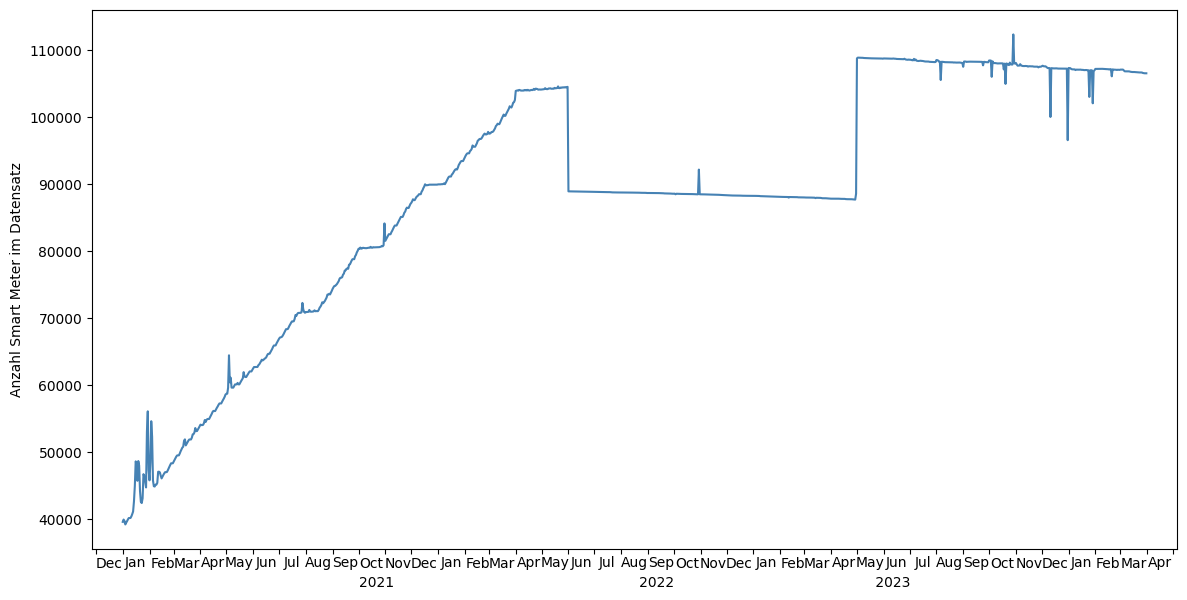

In [15]:
fig, ax = plt.subplots(figsize = (14,7)) 

ax.plot(df_day['date'], df_day['num_meter_datetime'], color = 'steelblue')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator())
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Minor tick labels anpassen
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

ax.set_xlabel("2021                                                        2022                                              2023")

plt.ylabel("Anzahl Smart Meter im Datensatz") # Y-Label
plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()

In [33]:
df_data = pd.read_pickle("data_add.pkl")
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year', 'month','date'])[['value_kwh']].mean() # Anzahl Smart Meter pro Tag
df_day = df_day.reset_index() # Index-Hierarchie aufheben

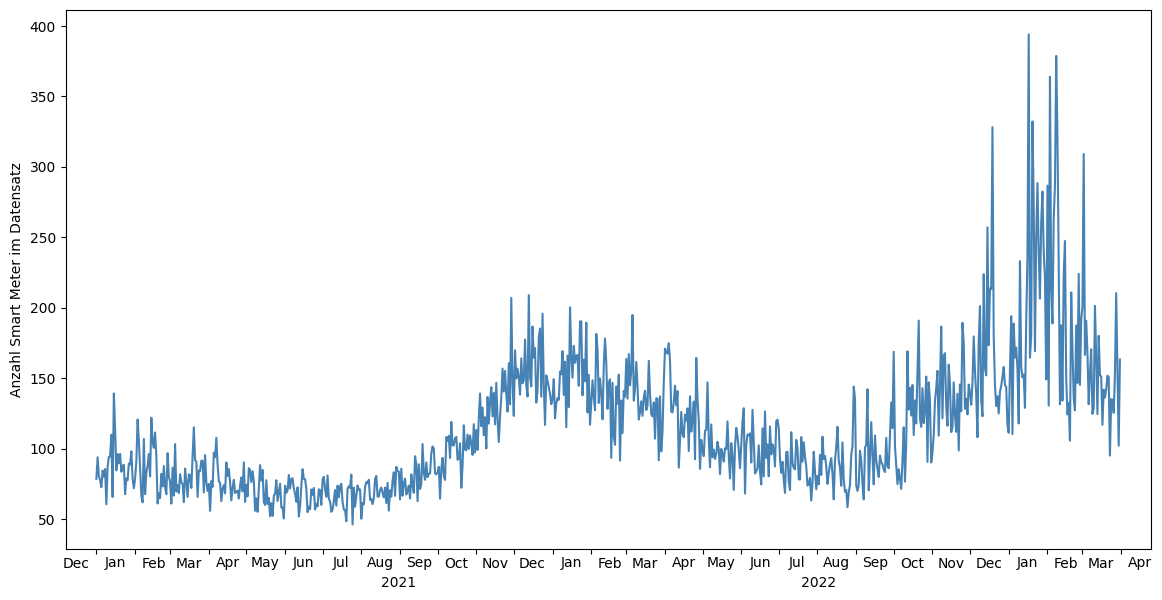

In [34]:
fig, ax = plt.subplots(figsize = (14,7)) 

ax.plot(df_day['date'], df_day['value_kwh'], color = 'steelblue')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator())
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Minor tick labels anpassen
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

ax.set_xlabel("2021                                                                                        2022")

plt.ylabel("Anzahl Smart Meter im Datensatz") # Y-Label
plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()

In [4]:
df_data = pd.read_pickle("data_add.pkl")
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year', 'month','date'])[['num_meter']].mean() # Anzahl Smart Meter pro Tag
df_day = df_day.reset_index() # Index-Hierarchie aufheben

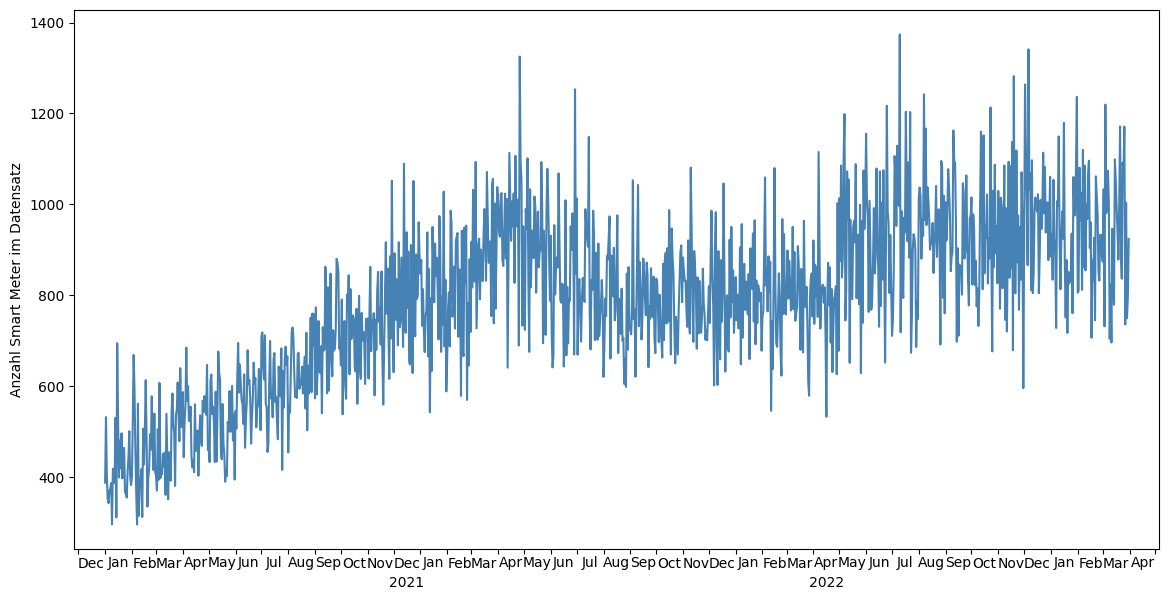

In [6]:
fig, ax = plt.subplots(figsize = (14,7)) 

ax.plot(df_day['date'], df_day['num_meter'], color = 'steelblue')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator())
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Minor tick labels anpassen
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

ax.set_xlabel("2021                                                                                        2022")

plt.ylabel("Anzahl Smart Meter im Datensatz") # Y-Label
plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()

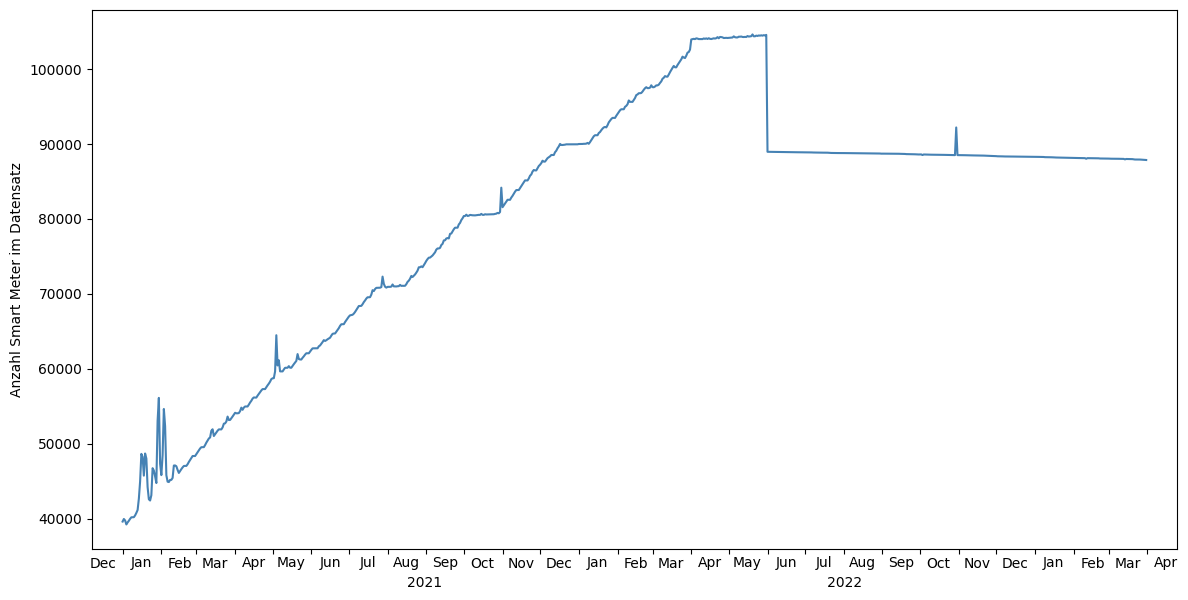

In [14]:
fig, ax = plt.subplots(figsize = (14,7)) 

ax.plot(df_day['date'], df_day['num_meter_datetime'], color = 'steelblue')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator())
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Minor tick labels anpassen
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

ax.set_xlabel("2021                                                                                        2022")

plt.ylabel("Anzahl Smart Meter im Datensatz") # Y-Label
plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()

In [35]:
df_data = pd.read_pickle("data_add.pkl")
#sns.set_theme() # definiere Seaborn als Plot-Stil
#sns.set(font_scale=1.1) # Anpassung Default-Schriftgrösse
#plt.rcParams["font.family"] = "Gotham Office"

In [40]:
# Datenaufbereitung

df_data['daymonth'] = df_data['date'] .dt.strftime('%m-%d') # Variable mit Tag-Monat
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year', 'month', 'daymonth', 'date'])[['kwh_per_meter']].sum() # Verbrauch pro Smart Meter pro Tag

df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_dayroll=df_day # Dataframe für rollierenden Verbrauch
df_dayroll['rollkwh'] = df_dayroll['kwh_per_meter'].rolling(7).mean() # rollierender Verbrauch über letzte 7 Tage

df_day=df_day.pivot_table(values="kwh_per_meter", index=['month','daymonth'], columns=["year"]).reset_index() # Pivot-Tabelle
#df_day.columns = ['month','date', '2021', '2022', '2023'] # Umbenennen Variablen

In [41]:
df_day

year,month,daymonth,2021,2022,2023
0,1,01-01,22.929030,18.075029,15.233409
1,1,01-02,23.000861,17.899355,18.008852
2,1,01-03,24.652520,17.879649,20.299558
3,1,01-04,27.184045,16.612681,17.146280
4,1,01-05,25.687130,20.963274,41.808700
...,...,...,...,...,...
360,12,12-27,19.181908,17.201319,NaN
361,12,12-28,20.137456,25.931987,NaN
362,12,12-29,19.203573,26.198318,NaN
363,12,12-30,15.545067,33.964254,NaN


In [38]:
df_day.columns = ['month','date', '2021', '2022', '2023'] # Umbenennen Variablen

In [39]:
df_day

,month,date,2021,2022,2023
0,1,01-01,22.929030,18.075029,15.233409
1,1,01-02,23.000861,17.899355,18.008852
2,1,01-03,24.652520,17.879649,20.299558
3,1,01-04,27.184045,16.612681,17.146280
4,1,01-05,25.687130,20.963274,41.808700
...,...,...,...,...,...
360,12,12-27,19.181908,17.201319,NaN
361,12,12-28,20.137456,25.931987,NaN
362,12,12-29,19.203573,26.198318,NaN
363,12,12-30,15.545067,33.964254,NaN


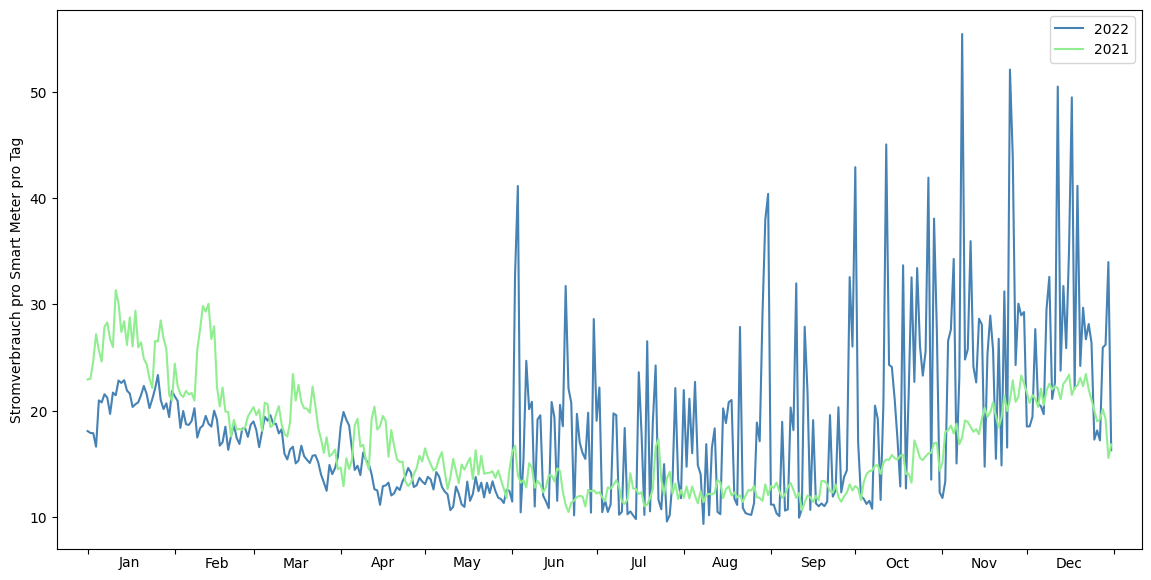

In [13]:
# Grafik mit Verbrauch pro Tag

fig, ax = plt.subplots(figsize = (14,7)) 

#ax.plot(df_day['date'], df_day['2023'], color = 'red', label='2023')
ax.plot(df_day['date'], df_day['2022'], color = 'steelblue', label='2022')
ax.plot(df_day['date'], df_day['2021'], color = 'lightgreen', label='2021')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator(bymonth=range(1,13,1))) # X-Ticks pro Monat
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Position Minor tick labels:
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

#ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sept', 'Okt','Nov', 'Dez'], minor=True) #  Anpassen Labels
plt.ylabel("Stromverbrauch pro Smart Meter pro Tag") # Y-Label
ax.legend() # Hinzufügen Legende

plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()

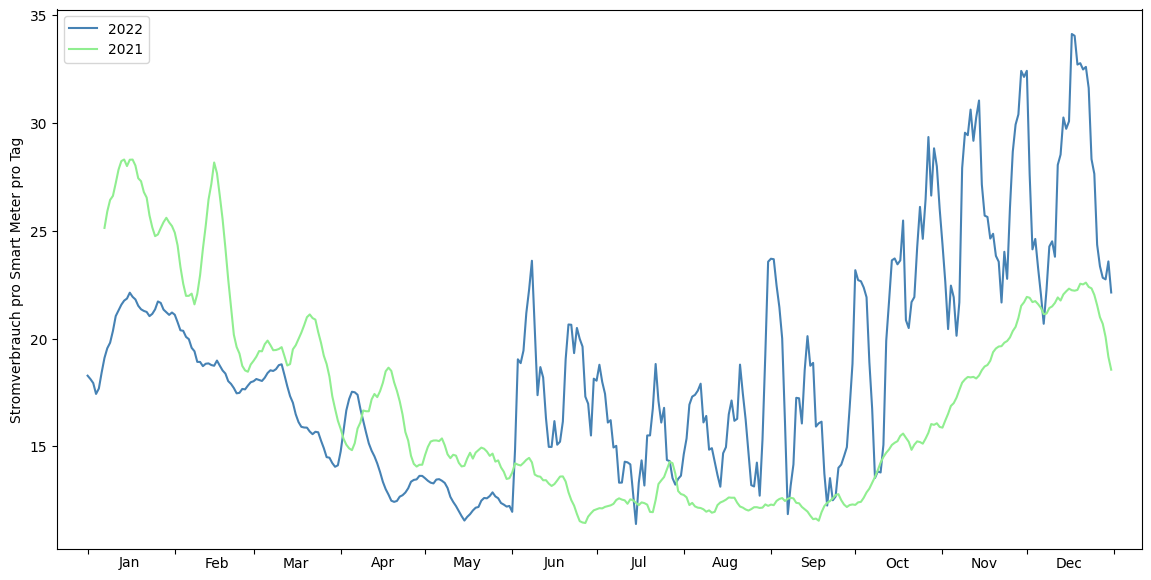

In [14]:
# Grafik mit rollierendem Verbrauch über letzte 7 Tage

df_dayroll=df_dayroll.pivot_table(values="rollkwh", index=['month','daymonth'], columns=["year"]).reset_index() # Pivot-Tabelle
df_dayroll.columns = ['month','date', '2021', '2022', '2023'] # Umbenennen Variablen

fig, ax = plt.subplots(figsize = (14,7)) 

ax.plot(df_dayroll['date'], df_dayroll['2022'], color = 'steelblue', label='2022')
ax.plot(df_dayroll['date'], df_dayroll['2021'], color = 'lightgreen', label='2021')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator(bymonth=range(1,13,1))) # X-Ticks pro Monat
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor-Ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Position Minor tick labels:
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

#ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sept', 'Okt','Nov', 'Dez'], minor=True) #  Anpassen Labels
plt.ylabel("Stromverbrauch pro Smart Meter pro Tag") # Y-Label
ax.legend() # Hinzufügen Legende

plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()

In [3]:
df_data['daymonth'] = df_data['date'] .dt.strftime('%m-%d') # Variable mit Tag-Monat
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year', 'month', 'daymonth', 'date'])[['kwh_per_meter']].sum() # Verbrauch pro Smart Meter pro Tag

df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_dayroll=df_day # Dataframe für rollierenden Verbrauch
df_dayroll['rollkwh'] = df_dayroll['kwh_per_meter'].rolling(7).mean() # rollierender Verbrauch über letzte 7 Tage

df_day=df_day.pivot_table(values="kwh_per_meter", index=['month','daymonth'], columns=["year"]).reset_index() # Pivot-Tabelle
#df_day.columns = ['month','date', '21', '2022', '2023'] # Umbenennen Variablen

In [4]:
# Datenaufbereitung

df_data['daymonth'] = df_data['date'] .dt.strftime('%m-%d') # Variable mit Tag-Monat
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year', 'month', 'daymonth', 'date', 'seasonyear', 'daytemp'])[['kwh_per_meter']].sum() # Verbrauch pro Smart Meter pro Tag

df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_dayroll=df_day # Dataframe für rollierenden Verbrauch
df_dayroll['rollkwh'] = df_dayroll['kwh_per_meter'].rolling(7).mean() # rollierender Verbrauch über letzte 7 Tage

df_day.dropna(subset=["seasonyear"]) # Löschen der Monate Jan / Feb / März 21
df_day=df_day.pivot_table(values=["kwh_per_meter", 'daytemp'], index=['month','daymonth'], columns=["seasonyear"]).reset_index() # Pivot-Tabelle

In [5]:
df_day = df_day.loc[(df_day['month'] < 4) | (df_day['month'] > 9)] # Filter für Wintermonate
df_day['month_name'] = df_day['month'].apply(lambda x: calendar.month_abbr[x]) # Hinzufügen Monat-Namen

# Sortierung Monate
df_day['month_name']= pd.Categorical(df_day['month_name'], ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]) 
df_day=df_day.sort_values(by=['month_name', 'daymonth'])
#df_day = df_day.groupby(['month_name']).apply(lambda x: x.sort_values(['daymonth'], ascending=True))

In [6]:
# Umbenennen Spalten
df_day.columns = pd.MultiIndex.from_tuples(df_day.set_axis(df_day.columns.values, axis=1)
                                       .rename(columns={   
                                                        ('month', ''): ('month', 'month'),
                                                        ('daymonth', ''): ('daymonth', 'date'),
                                                        ('month_name', ''): ('month_name', 'month_name'),
                                                        ('daytemp', 'Sommer 2021'): ('daytemp', 'Temp Sommer21'),
                                                        ('daytemp', 'Sommer 2022'): ('daytemp', 'Temp Sommer22'),
                                                        ('daytemp', 'Sommer 2023'): ('daytemp', 'Temp Sommer23'),
                                                        ('daytemp', 'Winter 2021/2022'): ('daytemp', 'Temp Winter21/22'),
                                                        ('daytemp', 'Winter 2022/2023'): ('daytemp', 'Temp Winter22/23'),
                                                        ('daytemp', 'Winter 2023/2024'): ('daytemp', 'Temp Winter23/24'),
                                                        ('kwh_per_meter', 'Sommer 2021'): ('kwh_per_meter', 'kwh Sommer21'),
                                                        ('kwh_per_meter', 'Sommer 2022'): ('kwh_per_meter', 'kwh Sommer22'),
                                                        ('kwh_per_meter', 'Sommer 2023'): ('kwh_per_meter', 'kwh Sommer23'),
                                                        ('kwh_per_meter', 'Winter 2021/2022'): ('kwh_per_meter', 'kwh Winter21/22'),
                                                        ('kwh_per_meter', 'Winter 2022/2023'): ('kwh_per_meter', 'kwh Winter22/23'),
                                                        ('kwh_per_meter', 'Winter 2023/2024'): ('kwh_per_meter', 'kwh Winter23/24')
                                                        }))

df_day=df_day.droplevel(0, axis=1)

df_day=df_day.drop(['Temp Sommer21', 'Temp Sommer22','Temp Sommer23','kwh Sommer21', 'kwh Sommer22', 'kwh Sommer23',], axis=1) # Löschen Sommermonate

In [7]:
# Berechnung temperatur-korrigierter Verbrauch
print("Temperatur 22/23:",df_day['Temp Winter22/23'].mean())
print("Temperatur 21/22:",df_day['Temp Winter21/22'].mean())
print("Temperatur-Differenz 21/22 to 22/23", df_day['Temp Winter22/23'].mean()-df_day['Temp Winter21/22'].mean())
      
df_day['kwh Winter21/22_tempkorr'] = df_day['kwh Winter21/22']-0.3804*(df_day['Temp Winter22/23']-df_day['Temp Winter21/22']) # kwH-Korrektur um Temperatureffekt, gemäss OLS-Modell-Schätzung
df_day['kwh Winter21/22_tempkorrmean'] = df_day['kwh Winter21/22']-0.3804*(df_day['Temp Winter22/23'].mean()-df_day['Temp Winter21/22'].mean())

df_diff = df_day[['kwh Winter22/23','kwh Winter21/22','kwh Winter21/22_tempkorr', 'kwh Winter21/22_tempkorrmean']].mean() # Durchschnittlicher Verbauch in Winterhalbjahren
df_diff = df_day[['kwh Winter23/24','kwh Winter22/23','kwh Winter22/23_tempkorr', 'kwh Winter22/23_tempkorrmean']].mean() # Durchschnittlicher Verbauch in Winterhalbjahren

print("Temperatur-Korrektur 2021/22 in %:", ((0.3804*(df_day['Temp Winter22/23'].mean()-df_day['Temp Winter21/22'].mean()))/df_day['kwh Winter21/22'].mean())*100) # Relative Korrektur Verbrauchsdaten

Temperatur 22/23: 6.275824175824176
Temperatur 21/22: 4.918131868131868
Temperatur-Differenz 21/22 to 22/23 1.3576923076923073


KeyError: "['kwh Winter22/23_tempkorr', 'kwh Winter22/23_tempkorrmean'] not in index"

In [ ]:
# Berechnung temperatur-korrigierter Verbrauch
print("Temperatur 22/23:",df_day['Temp Winter22/23'].mean())
print("Temperatur 21/22:",df_day['Temp Winter21/22'].mean())
print("Temperatur-Differenz", df_day['Temp Winter22/23'].mean()-df_day['Temp Winter21/22'].mean())
      
df_day['kwh Winter21/22_tempkorr'] = df_day['kwh Winter21/22']-0.3804*(df_day['Temp Winter22/23']-df_day['Temp Winter21/22']) # kwH-Korrektur um Temperatureffekt, gemäss OLS-Modell-Schätzung
df_day['kwh Winter21/22_tempkorrmean'] = df_day['kwh Winter21/22']-0.3804*(df_day['Temp Winter22/23'].mean()-df_day['Temp Winter21/22'].mean()) 

df_diff = df_day[['kwh Winter22/23','kwh Winter21/22','kwh Winter21/22_tempkorr', 'kwh Winter21/22_tempkorrmean']].mean() # Durchschnittlicher Verbauch in Winterhalbjahren

print("Temperatur-Korrektur 2021/22 in %:", ((0.3804*(df_day['Temp Winter22/23'].mean()-df_day['Temp Winter21/22'].mean()))/df_day['kwh Winter21/22'].mean())*100) # Relative Korrektur Verbrauchsdaten

Temperatur 22/23: 6.275824175824176
Temperatur 21/22: 4.918131868131868
Temperatur-Differenz 1.3576923076923073
Temperatur-Korrektur 2021/22 in %: 2.7865961586697887


In [ ]:
print("Temperatur 23/24:",df_day['Temp Winter23/24'].mean())
print("Temperatur-Differenz 22/23 to 23/24", df_day['Temp Winter23/24'].mean()-df_day['Temp Winter22/23'].mean())

df_day['kwh Winter22/23_tempkorr'] = df_day['kwh Winter22/23']-0.3804*(df_day['Temp Winter23/24']-df_day['Temp Winter22/23']) # kwH-Korrektur um Temperatureffekt, gemäss OLS-Modell-Schätzung
df_day['kwh Winter22/23_tempkorrmean'] = df_day['kwh Winter22/23']-0.3804*(df_day['Temp Winter23/24'].mean()-df_day['Temp Winter22/23'].mean())
print("Temperatur-Korrektur 22/23 in %:", ((0.3804*(df_day['Temp Winter23/24'].mean()-df_day['Temp Winter22/23'].mean()))/df_day['kwh Winter22/23'].mean())*100) # Relative Korrektur Verbrauchsdaten

In [ ]:
print(df_diff)
print("Durchschnittliche Differenz in kWh pro Smart Meter pro Tag (22/23 vs. 21/22):",df_day['kwh Winter22/23'].mean() - df_day['kwh Winter21/22_tempkorr'].mean()) # Unterschied in Winterhalbjahren
print("Differenz in kWh pro Smart Meter pro Tag in % (22/23 vs. 21/22):",((df_day['kwh Winter22/23'].mean() - df_day['kwh Winter21/22_tempkorr'].mean())/df_day['kwh Winter21/22_tempkorr'].mean())*100) # Unterschied in Winterhalbjahren --> evt. auf Jahr 22/23 beziehen
print("Durchschnittliche Differenz in kWh pro Smart Meter Winter Total (22/23 vs. 21/22):",df_day['kwh Winter22/23'].sum() - df_day['kwh Winter21/22_tempkorr'].sum()) # Unterschied in Winterhalbjahren pro SM Total
print("Durchschnittliche Differenz in MWh für Versorgungsgebiet Winter Total (22/23 vs. 21/22):",((df_day['kwh Winter22/23'].sum() - df_day['kwh Winter21/22_tempkorr'].sum())*150797)/1000) # Unterschied in Winterhalbjahren Versorgungsgebiet (Annahme: 150'797 SM < 25 MWh)

kwh Winter22/23                 26.884218
kwh Winter21/22                 18.533943
kwh Winter21/22_tempkorr        18.017477
kwh Winter21/22_tempkorrmean    18.017477
dtype: float64
Durchschnittliche Differenz in kWh pro Smart Meter pro Tag (22/23 vs. 21/22): 8.866740577888343
Differenz in kWh pro Smart Meter pro Tag in % (22/23 vs. 21/22): 49.211887292569386
Durchschnittliche Differenz in kWh pro Smart Meter Winter Total (22/23 vs. 21/22): 1613.7467851756783
Durchschnittliche Differenz in MWh für Versorgungsgebiet Winter Total (22/23 vs. 21/22): 243348.17396413675


In [ ]:
print("Durchschnittliche Differenz in kWh pro Smart Meter pro Tag (23/24 vs. 22/23):",df_day['kwh Winter23/24'].mean() - df_day['Winter22/23_tempkorr'].mean()) # Unterschied in Winterhalbjahren
print("Differenz in kWh pro Smart Meter pro Tag in % (23/24 vs. 22/23):",((df_day['kwh Winter23/24'].mean() - df_day['Winter22/23_tempkorr'].mean())/df_day['Winter22/23_tempkorr'].mean())*100) # Unterschied in Winterhalbjahren --> evt. auf Jahr 22/23 beziehen
print("Durchschnittliche Differenz in kWh pro Smart Meter Winter Total (23/24 vs. 22/23):",df_day['kwh Winter23/24'].sum() - df_day['Winter22/23_tempkorr'].sum()) # Unterschied in Winterhalbjahren pro SM Total
print("Durchschnittliche Differenz in MWh für Versorgungsgebiet Winter Total (23/24 vs. 22/23):",((df_day['kwh Winter23/24'].sum() - df_day['Winter22/23_tempkorr'].sum())*150797)/1000) # Unterschied in Winterhalbjahren Versorgungsgebiet (Annahme: 150'797 SM < 25 MWh)

Durchschnittliche Differenz in kWh pro Smart Meter pro Tag (23/24 vs. 22/23): -10.1559908013909
Differenz in kWh pro Smart Meter pro Tag in % (23/24 vs. 22/23): -37.982300097881144
Durchschnittliche Differenz in kWh pro Smart Meter Winter Total (23/24 vs. 22/23): -1831.8075705143096
Durchschnittliche Differenz in MWh für Versorgungsgebiet Winter Total (23/24 vs. 22/23): -276231.0862108464


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/ckw-stea/OneDrive - CKW-Gruppe/Desktop/Python/Grafiken/Winter.pdf'

findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font family 'Gotham Office' not found.
findfont: Font famil

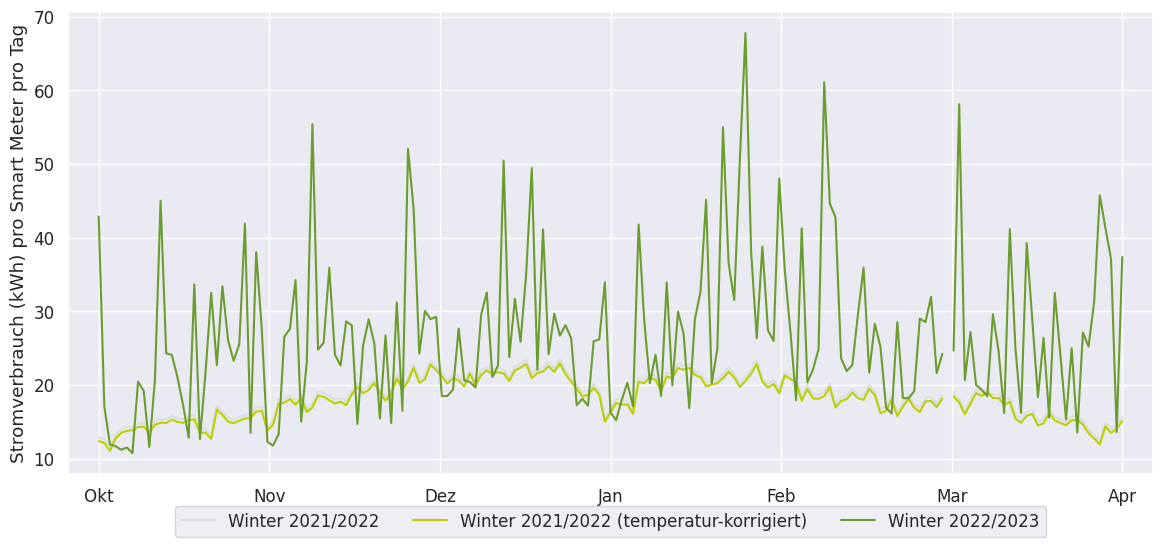

In [ ]:
# Grafik temparaturkorrigierter Verbrauch Wintermonate

fig, ax = plt.subplots(figsize = (14,6)) 

ax.plot(df_day['date'], df_day['kwh Winter21/22'], color = '#DBDFDB', label='Winter 2021/2022')
#ax.plot(df_day['date'], df_day['kwh Winter21/22_tempkorr'], color = 'steelblue', label='Winter 2021/2022 (temperatur-korrigiert)')
ax.plot(df_day['date'], df_day['kwh Winter21/22_tempkorrmean'], color = '#BCCF02', label='Winter 2021/2022 (temperatur-korrigiert)')
ax.plot(df_day['date'], df_day['kwh Winter22/23'], color = '#6C9C30', label='Winter 2022/2023')

#Zentrierte X-Achsen Labels 
months = ['Okt', 'Nov', 'Dez', 'Jan', 'Feb', 'Mar', 'Apr']
new_m=[]
for m in months: #'', 'Jan', 'Feb', ...
   new_m.append('        %s'%m) # Leerschläge vor Monatsname

plt.xticks(np.linspace(0,182,7), new_m)
plt.xticks(np.linspace(0,182,7), months)

plt.ylabel("Stromverbrauch (kWh) pro Smart Meter pro Tag") # Y-Label
ax.legend() # Hinzufügen Legende

plt.margins(x=0.03) # Anpassen Seitenrand

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=False, ncol=5)

plt.savefig("C:/Users/ckw-stea/OneDrive - CKW-Gruppe/Desktop/Python/Grafiken/Winter.pdf", format='pdf')
plt.show()

In [11]:
import matplotlib.font_manager as fm
print(sorted(fm.get_font_names()))

['DejaVu Math TeX Gyre', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif Display', 'STIXGeneral', 'STIXNonUnicode', 'STIXSizeFiveSym', 'STIXSizeFourSym', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'Ubuntu', 'Ubuntu Condensed', 'Ubuntu Mono', 'cmb10', 'cmex10', 'cmmi10', 'cmr10', 'cmss10', 'cmsy10', 'cmtt10']
